Visualize and load the DATASET: EMNIST "Balanced"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Training Data: 
Testing Data: 112800
Training Data: 18800
Total: 131600
Number of classes in EMNIST balanced dataset: 47


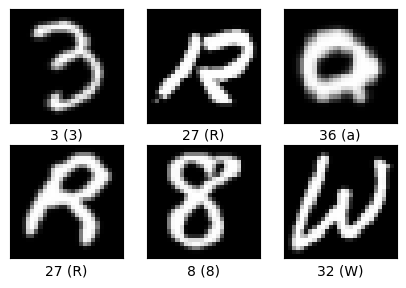

Number of training samples: 112800
Number of testing samples: 18800


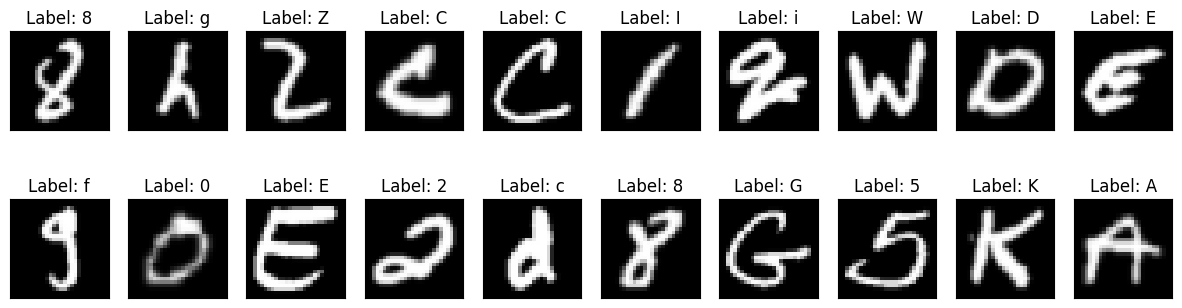

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
!pip install emnist
!pip install keras_tuner
from tensorflow.keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras import regularizers
from keras.metrics import Accuracy, Precision, Recall
from emnist import extract_training_samples, extract_test_samples
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import tensorflow as tf
import tensorflow_datasets as tfds

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np



# Load EMNIST dataset
(x_train, y_train), (x_test, y_test) = extract_training_samples('balanced'), extract_test_samples('balanced')


# Add an extra dimension for the channel
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


# Normalize the data
x_train_normalized = x_train/255.0
x_test_normalized = x_test/255.0


# Map labels to ASCII values
def map_to_ascii(label):
    if label >= 0 and label <= 9:
        return chr(label + 48)
    elif label >= 10 and label <= 35:
        return chr(label + 55)
    elif label >= 36 and label <= 61:
        return chr(label + 61)
    else:
        return None


# Print shape of data
print("Training Data: ")
print("Testing Data: " + str(len(x_train_normalized)))
print("Training Data: " + str(len(x_test_normalized)))
print("Total: " + str(len(x_train_normalized)+len(x_test_normalized)))
print('Number of classes in EMNIST balanced dataset:', "47")




# Visualize the sample images
plt.figure(figsize=(5,5))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_idx = np.random.randint(len(x_train))
    img = x_train[img_idx]
    label = y_train[img_idx]
    ascii_label = map_to_ascii(label)
    if ascii_label is not None:
        plt.xlabel(str(label) + " (" + ascii_label + ")")
    plt.imshow(img, cmap='gray')
plt.show()


# Load the dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)


# Split data into a training dataset and a testing dataset
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)


# Understand the dataset and visualize the dataset
print(f'Number of training samples: {len(train_data)}')
print(f'Number of testing samples: {len(test_data)}')


# Plot some figures to visualize some samples in the dataset
import matplotlib.pyplot as plt


dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()


# Define the list of character classes
classes = [chr(i) for i in range(48, 58)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]


# Define a dictionary to map the index to the corresponding class
mapping = {i: c for i, c in enumerate(classes)}


# Visualize the labels using the mapping dictionary
fig = plt.figure(figsize=(15, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    image = images[idx].squeeze()
    image = np.fliplr(image)
    image = np.rot90(image)
    ax.imshow(image, cmap='gray')
    label = "Label: " + mapping[labels[idx].item()]
    ax.set_title(label)
plt.show()


Create MLP model

In [ ]:
!pip install emnist
!pip install keras_tuner
from emnist import extract_training_samples, extract_test_samples
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.callbacks import LearningRateScheduler
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import math


# Load the EMNIST balanced training and test data
X_train, y_train = extract_training_samples('balanced')
X_test, y_test = extract_test_samples('balanced')


# Reshape the data to 2D (28x28 pixels)
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)


# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


# Set the number of input and output nodes
n_input = 784 # Number of input nodes (28x28 pixels)
n_output = 47 # Number of output nodes (47 classes in EMNIST balanced)


def build_model(hp):
    # Create a sequential model
    model = Sequential()


    # Add at least three hidden layers with a tunable number of neurons in each layer
    for i in range(hp.Int('num_layers', min_value=3, max_value=5, step=1)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                        input_shape=(n_input,) if i == 0 else (),
                        activation=hp.Choice('activation', values=['relu', 'elu', 'leaky_relu']),
                        kernel_regularizer=l1_l2(l1=hp.Float('l1', min_value=0.0, max_value=0.1, step=0.05),
                                                  l2=hp.Float('l2', min_value=0.0, max_value=0.1, step=0.05))))
        if hp.Boolean('batch_normalization'):
            model.add(BatchNormalization())
        if hp.Boolean('dropout'):
            model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.25)))


    # Add the output layer with softmax activation
    model.add(Dense(n_output, activation='softmax'))


    # Compile the model using a tunable optimizer and categorical crossentropy loss
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


    # Define step decay function
    def step_decay(epoch):
        initial_lrate = hp.Float('initial_lrate', min_value=0.001, max_value=0.1, step=0.005)
        drop = hp.Float('drop', min_value=0.1, max_value=0.9, step=0.1)
        epochs_drop = hp.Int('epochs_drop', min_value=1, max_value=10, step=1)
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lrate


    # Define exponential decay function
    def exp_decay(epoch):
        initial_lrate = hp.Float('initial_lrate', min_value=0.001, max_value=0.1, step=0.005)
        k = hp.Float('k', min_value=0.1, max_value=0.9, step=0.1)
        lrate = initial_lrate * math.exp(-k*epoch)
        return lrate


    # Choose a learning rate schedule method (step_decay or exp_decay)
    schedule_name = hp.Choice('schedule', values=['step_decay', 'exp_decay'])
    if schedule_name == 'step_decay':
        lrate_schedule = LearningRateScheduler(step_decay)
    else:
        lrate_schedule = LearningRateScheduler(exp_decay)
    return model


# Create a random search tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')


# Search for the best hyperparameters
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))


# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]


# Print the best hyperparameters




# # Build the best model
# best_model = tuner.hypermodel.build(best_hp)


# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hp)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


# Evaluate the best model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


print("Best Hyperparameters:")
print(best_hp.values)
for hp_name, hp_value in best_hp.values.items():
    print(f"{hp_name}: {hp_value}")


# # Evaluate the best model on the test data
# loss, accuracy = best_model.evaluate(X_test, y_test)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)


Plot accuracy and loss graphs

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss function graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy graph
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



Plot Confusion Matrix and Precision, Recall, F1 Score


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate the precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print the precision, recall, and F1 score
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')


Predict top 6 samples from trained Model

In [ ]:
# Predict labels for the test data
y_pred = model.predict(X_test)

# Get the index of the highest predicted probability for each image
y_pred_idx = y_pred.argmax(axis=1)

# Get the index of the true label for each image
y_true_idx = y_test.argmax(axis=1)

# Get the top six images with the highest prediction accuracy
top_six_idx = np.argsort(y_pred.max(axis=1))[-6:]

# Print the top six images with their true and predicted labels
for i, idx in enumerate(top_six_idx):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_idx[idx]}\nPredicted: {y_pred_idx[idx]}")
plt.show()



CNN MODEL

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
!pip install emnist
!pip install keras_tuner
from tensorflow.keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras import regularizers
from keras.metrics import Accuracy, Precision, Recall
from emnist import extract_training_samples, extract_test_samples
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import time

x_train, y_train = extract_training_samples('balanced') # Traing dataset balanced
final_x_test, final_y_test = extract_test_samples('balanced') # Testing dataset balanced

# Normalizing the data
x_train_normalized = x_train/255.0
final_x_test_normalized = final_x_test/255.0

x_train_normalized=x_train_normalized.reshape(len(x_train_normalized),28,28,1)
final_x_test_normalized=final_x_test_normalized.reshape(len(final_x_test_normalized),28,28,1)

print(x_train_normalized.shape)
print(y_train.shape)
print(final_x_test_normalized.shape)
print(final_y_test.shape)

# mapping_txt = pd.read_csv('C:/Users/rrhl2/Downloads/emnist-balanced-mapping.txt', header= None, sep = ' ')
# mapping_txt.columns = ['1', '2']
# print(chr(mapping_txt.loc[mapping_txt['1'] == y_train[57], '2'].item())) # print(mapping_txt.iloc[3,:])
# plt.imshow(x_train[57], cmap='gray')
# plt.axis('off')
# plt.show()



def create_model(hp):
    model = Sequential()

    # Tune the number of filters in the first convolutional layer
    hp_filters = hp.Choice("filters", values=[32, 64, 128])

    model.add(
        Conv2D(
            hp_filters,
            kernel_size=(3, 3),
            activation=hp.Choice("conv_activation", values=["relu", "leaky_relu", "elu"]),
            input_shape=(28, 28, 1)
        )
    )

    model.add(MaxPooling2D(pool_size=(2, 2)))

    if hp.Boolean("batch_normalization"):
        model.add(BatchNormalization())

    model.add(Flatten())

    # Tune the number of hidden layers
    for i in range(hp.Int("num_hidden_layers", min_value=1, max_value=3)):
        # Tune the number of units in the dense layer
        hp_units = hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)

        model.add(Dense(hp_units,
                        activation=hp.Choice("dense_activation", values=["relu", "leaky_relu", "elu"]),
                        kernel_regularizer=regularizers.l1_l2(l1=hp.Float("l1", min_value=0.0,
                                                                           max_value=0.01,
                                                                           default=0.01,
                                                                           step=0.01),
                                                               l2=hp.Float("l2", min_value=0.0,
                                                                           max_value=0.01,
                                                                           default=0.01,
                                                                           step=0.01))))

        if hp.Boolean("dropout"):
            model.add(Dropout(rate=hp.Float("dropout_rate",
                                            min_value=0.0,
                                            max_value=0.5,
                                            default=0.25,
                                            step=0.05)))

    model.add(Dense(47, activation="softmax"))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    # Tune the optimizer
    hp_optimizer = hp.Choice("optimizer", values=["sgd", "adam", "rmsprop"])

    model.compile(
        optimizer=get_optimizer(hp_optimizer,hp_learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


def get_optimizer(name: str,hp_learning_rate):
    if name == "sgd":
        return keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif name == "adam":
        return keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif name == "rmsprop":
        return keras.optimizers.RMSprop(learning_rate=hp_learning_rate)

# Define the tuner
tuner = RandomSearch(
    create_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=3,
    directory="tuner_dir",
    project_name="emnist_tuning",
)

def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

start_time = time.time()

# Search for the best hyperparameters
tuner.search(x_train_normalized,y_train,batch_size=32,callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch))],epochs=10, validation_split=0.1)
CNN_ = tuner.get_best_models(num_models = 1)[0]

end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"""
The best hyperparameters found are:
Number of filters: {best_hps.get('filters')}
Convolutional layer activation function: {best_hps.get('conv_activation')}
Batch normalization: {best_hps.get('batch_normalization')}
Number of hidden layers: {best_hps.get('num_hidden_layers')}
Dense layer activation function: {best_hps.get('dense_activation')}
L1 regularization: {best_hps.get('l1')}
L2 regularization: {best_hps.get('l2')}
Dropout: {best_hps.get('dropout')}
Dropout rate: {best_hps.get('dropout_rate')}
Learning rate: {best_hps.get('learning_rate')}
Optimizer: {best_hps.get('optimizer')}
""")

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
model = best_model.fit(x_train_normalized, y_train, epochs = 10, validation_data=(final_x_test_normalized, final_y_test))


# Evaluate the best model on the test set
test_loss, test_acc = best_model.evaluate(final_x_test_normalized, final_y_test)

print("Test accuracy:", test_acc)

Plot accuracy and loss graphs

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.plot(model.history['loss'], label = 'train')
plt.plot(model.history['val_loss'], label = 'test')
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(model.history['accuracy'], label = 'train')
plt.plot(model.history['val_accuracy'], label = 'test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plot Confusion Matrix and Precision, Recall, F1 Score

In [ ]:
# Predicting the labels of the test set
y_pred = CNN_.predict(final_x_test_normalized)
y_pred_labels = np.argmax(y_pred, axis=1)


# Creating the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(final_y_test, y_pred_labels)


# Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Calculating precision, recall, and F1-score
from sklearn.metrics import classification_report
print(classification_report(final_y_test, y_pred_labels))


Predict top 6 samples from trained Model

In [ ]:
import tensorflow as tf
import numpy as np

CNN_.save("my_model.h5")

# Load the model
loaded_model = keras.models.load_model("my_model.h5")

# Print the prediction of the top six samples in the testing dataset
predictions = loaded_model.predict(final_x_test_normalized[:6])
predicted_labels = np.argmax(predictions, axis=1)

# Compare the predicted labels with the true labels
for i in range(6):
    print(f"Sample {i + 1}: predicted label = {predicted_labels[i]}, true label = {final_y_test[i]}")


# Load your model and make predictions on the testing dataset
loaded_model = keras.models.load_model("my_model.h5")
predictions = loaded_model.predict(final_x_test_normalized)

# Get the top 6 predictions with their corresponding true labels
top_predictions = np.argsort(predictions, axis=1)[:, -6:][:, ::-1]
true_labels = final_y_test[np.arange(len(predictions))]

# Display the images for the first 6 samples
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(final_x_test_normalized[i], cmap='gray')
    ax.set_title(f"Predicted: {top_predictions[i][0]} / True: {true_labels[i]}")
    ax.axis('off')
    
    if i == 5:
        break

plt.tight_layout()
plt.show()